In [1]:
import matplotlib.pyplot as plt
import pickle
import os
import numpy as np

# Calc FLOPS

In [2]:
from calc_pseudo import clean, basic_flops
B_TARGET_PANEL_WIDTH = 48

In [3]:
MAT_PATH = "./../../../synth_mats/"
mat_paths = sum([[os.path.join(dir, file) for file in files] for dir, _, files in os.walk(MAT_PATH)], [])

In [4]:
mat_flops = {}

In [5]:
for mat_path in mat_paths:
    with open(mat_path) as f:
        test_mat = clean(np.loadtxt(f))
    FLOPS_PER_PANEL = basic_flops(test_mat, B_TARGET_PANEL_WIDTH)
    
    mat_flops[mat_path.split("./../../../")[1]] = FLOPS_PER_PANEL

## Load Data

In [6]:
HYBRID_DIR = "./../../../logs/hybrid/synth/"

GIMMIK_DIR  = "./../../../logs/gimmik/synth/"

RP_DIR     = "./../../../logs/reg_pack/synth/"
DENSE_DIR  = "./../../../logs/reg_pack/synth/dense_unique/"

In [7]:
hybrid_runs = []
gimmik_runs = []
rp_runs = []
dense_runs = []

In [8]:
NUM_RUNS = 3

for i in range(1,NUM_RUNS+1):
    with open(HYBRID_DIR+"run_{}.dat".format(i), "rb") as f:
        hybrid_runs.append( pickle.load(f) )
    with open(GIMMIK_DIR+"run_{}.dat".format(i), "rb") as f:
        gimmik_runs.append( pickle.load(f) )
    with open(RP_DIR+"run_{}.dat".format(i), "rb") as f:
        rp_runs.append( pickle.load(f) )
    with open(DENSE_DIR+"run_{}.dat".format(i), "rb") as f:
        dense_runs.append( pickle.load(f) )

## Sort Data

In [9]:
def sort_values(x_term, run, mat_flops, t='best'):
    NUM_PANELS = 192000 / 48

    local_best = []
    ref_best = []
    local_best_x, local_best_y = [], []
    ref_best_x, ref_best_y = [], []

    for i, u in enumerate(run[x_term]):
        FLOPS_PER_PANEL = mat_flops[run['mat_file'][i]]

        time_per_panel_local = (run['xsmm_local_'+t][i]*1e-3)/NUM_PANELS
        time_per_panel_ref   = (run['xsmm_upstream_'+t][i]*1e-3)/NUM_PANELS
        
        local_best_x.append(u)
        local_best_y.append(FLOPS_PER_PANEL / time_per_panel_local)
        ref_best_x.append(u)
        ref_best_y.append(FLOPS_PER_PANEL / time_per_panel_ref)
    
    old_len = len(local_best_y)

    local_best_y = [x for _,x in sorted(zip(local_best_x,local_best_y))]
    local_best_x.sort()
    
    assert(old_len == len(local_best_y))

    ref_best_y = [x for _,x in sorted(zip(ref_best_x,ref_best_y))]
    ref_best_x.sort()

    return local_best_x, local_best_y, ref_best_x, ref_best_y

def sort_values_gimmik(x_term, run, mat_flops, t='best'):
    NUM_PANELS = 192000 / 48

    best = []
    best_x = []
    best_y = []

    for i, u in enumerate(run[x_term]):
        FLOPS_PER_PANEL = mat_flops[run['mat_file'][i]]

        time_per_panel = (run['gimmik_'+t][i]*1e-3)/NUM_PANELS
        
        best_x.append(u)
        best_y.append(FLOPS_PER_PANEL / time_per_panel)
    
    old_len = len(best_y)

    best_y = [x for _,x in sorted(zip(best_x,best_y))]
    best_x.sort()
    
    assert(old_len == len(best_y))


    return best_x, best_y

In [10]:
def get_local_upstream_perf(runs, shape, x_term):
    global mat_flops
    local_best_x1, local_best_y1, ref_best_x1, ref_best_y1 = \
        sort_values(x_term, runs[0][shape], mat_flops, 'best')
    local_best_x2, local_best_y2, ref_best_x2, ref_best_y2 = \
        sort_values(x_term, runs[1][shape], mat_flops, 'best')
    local_best_x3, local_best_y3, ref_best_x3, ref_best_y3 = \
        sort_values(x_term, runs[2][shape], mat_flops, 'best')

    local_best_y_avg = [sum(elem)/len(elem) for elem in zip(local_best_y1, local_best_y2, local_best_y3)]
    ref_best_y_avg = [sum(elem)/len(elem) for elem in zip(ref_best_y1, ref_best_y2, ref_best_y3)]
    
    return local_best_x1, local_best_y_avg, ref_best_y_avg

def get_gimmik_perf(runs, shape, x_term):
    global mat_flops
    best_x1, best_y1 = sort_values_gimmik(x_term, runs[0][shape], mat_flops, 'best')
    best_x2, best_y2 = sort_values_gimmik(x_term, runs[1][shape], mat_flops, 'best')
    best_x3, best_y3 = sort_values_gimmik(x_term, runs[2][shape], mat_flops, 'best')

    best_y_avg = [sum(elem)/len(elem) for elem in zip(best_y1, best_y2, best_y3)]
    
    return best_x1, best_y_avg

## Vary Rows

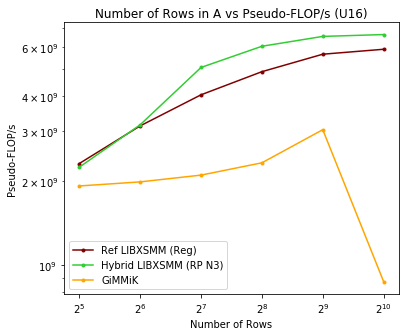

In [11]:
x_term="a_rows"
plt.figure(figsize=(6,5))

hybrid_xvals, hybrid_avg, _ = get_local_upstream_perf(hybrid_runs, "vary_row/q_16", x_term)
gimmik_xvals, gimmik_avg = get_gimmik_perf(gimmik_runs, "vary_row/q_16", x_term)
rp_xvals, _, ref_avg = get_local_upstream_perf(rp_runs, "vary_row/q_16", x_term)

plt.plot(rp_xvals, ref_avg, label="Ref LIBXSMM (Reg)", color="maroon", marker=".")
plt.plot(hybrid_xvals, hybrid_avg, label="Hybrid LIBXSMM (RP N3)", color="limegreen", marker=".")
plt.plot(gimmik_xvals, gimmik_avg, label="GiMMiK", color="orange", marker=".")  

plt.xlabel("Number of Rows")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.xscale("log", basex=2)
plt.title("Number of Rows in A vs Pseudo-FLOP/s (U16)")
plt.legend()
plt.savefig("./../../../plots/libxsmm_vs_gimmik/synth/vary_row_16.pdf")
plt.show()

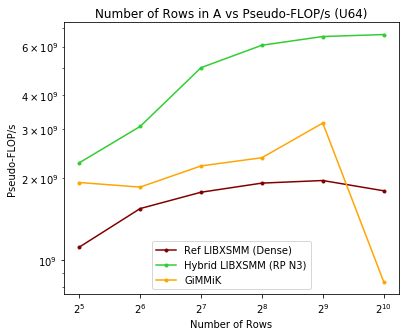

In [12]:
x_term="a_rows"
plt.figure(figsize=(6,5))

hybrid_xvals, hybrid_avg, _ = get_local_upstream_perf(hybrid_runs, "vary_row/q_64", x_term)
gimmik_xvals, gimmik_avg = get_gimmik_perf(gimmik_runs, "vary_row/q_64", x_term)
rp_xvals, _, ref_avg = get_local_upstream_perf(rp_runs, "vary_row/q_64", x_term)

plt.plot(rp_xvals, ref_avg, label="Ref LIBXSMM (Dense)", color="maroon", marker=".")
plt.plot(hybrid_xvals, hybrid_avg, label="Hybrid LIBXSMM (RP N3)", color="limegreen", marker=".")
plt.plot(gimmik_xvals, gimmik_avg, label="GiMMiK", color="orange", marker=".")  

plt.xlabel("Number of Rows")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.xscale("log", basex=2)
plt.title("Number of Rows in A vs Pseudo-FLOP/s (U64)")
plt.legend()
plt.savefig("./../../../plots/libxsmm_vs_gimmik/synth/vary_row_64.pdf")
plt.show()

## Vary Columns

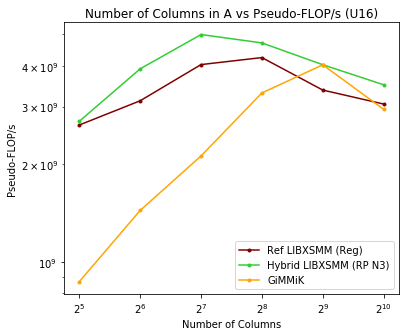

In [13]:
x_term="a_cols"
plt.figure(figsize=(6,5))

hybrid_xvals, hybrid_avg, _ = get_local_upstream_perf(hybrid_runs, "vary_col/q_16", x_term)
gimmik_xvals, gimmik_avg = get_gimmik_perf(gimmik_runs, "vary_col/q_16", x_term)
rp_xvals, _, ref_avg = get_local_upstream_perf(rp_runs, "vary_col/q_16", x_term)

plt.plot(rp_xvals, ref_avg, label="Ref LIBXSMM (Reg)", color="maroon", marker=".")
plt.plot(hybrid_xvals, hybrid_avg, label="Hybrid LIBXSMM (RP N3)", color="limegreen", marker=".")
plt.plot(gimmik_xvals, gimmik_avg, label="GiMMiK", color="orange", marker=".")  

plt.xlabel("Number of Columns")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.xscale("log", basex=2)
plt.title("Number of Columns in A vs Pseudo-FLOP/s (U16)")
plt.legend()
plt.savefig("./../../../plots/libxsmm_vs_gimmik/synth/vary_cols_16.pdf")
plt.show()

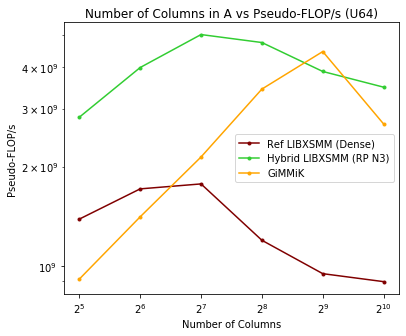

In [14]:
x_term="a_cols"
plt.figure(figsize=(6,5))

hybrid_xvals, hybrid_avg, _ = get_local_upstream_perf(hybrid_runs, "vary_col/q_64", x_term)
gimmik_xvals, gimmik_avg = get_gimmik_perf(gimmik_runs, "vary_col/q_64", x_term)
rp_xvals, _, ref_avg = get_local_upstream_perf(rp_runs, "vary_col/q_64", x_term)

plt.plot(rp_xvals, ref_avg, label="Ref LIBXSMM (Dense)", color="maroon", marker=".")
plt.plot(hybrid_xvals, hybrid_avg, label="Hybrid LIBXSMM (RP N3)", color="limegreen", marker=".")
plt.plot(gimmik_xvals, gimmik_avg, label="GiMMiK", color="orange", marker=".")  

plt.xlabel("Number of Columns")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.xscale("log", basex=2)
plt.title("Number of Columns in A vs Pseudo-FLOP/s (U64)")
plt.legend()
plt.savefig("./../../../plots/libxsmm_vs_gimmik/synth/vary_cols_64.pdf")
plt.show()

## Vary Density

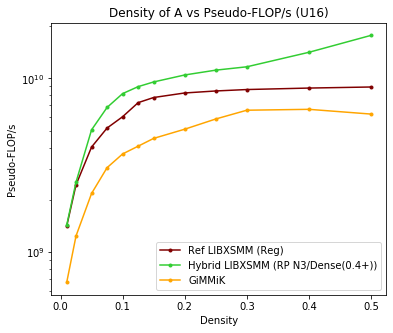

In [15]:
x_term="density"
plt.figure(figsize=(6,5))

hybrid_xvals, hybrid_avg, _ = get_local_upstream_perf(hybrid_runs, "vary_density/q_16", x_term)
gimmik_xvals, gimmik_avg = get_gimmik_perf(gimmik_runs, "vary_density/q_16", x_term)
rp_xvals, _, ref_avg = get_local_upstream_perf(rp_runs, "vary_density/q_16", x_term)

plt.plot(rp_xvals, ref_avg, label="Ref LIBXSMM (Reg)", color="maroon", marker=".")
plt.plot(hybrid_xvals, hybrid_avg, label="Hybrid LIBXSMM (RP N3/Dense(0.4+))", color="limegreen", marker=".")
plt.plot(gimmik_xvals, gimmik_avg, label="GiMMiK", color="orange", marker=".")  

plt.xlabel("Density")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.title("Density of A vs Pseudo-FLOP/s (U16)")
plt.legend()
plt.savefig("./../../../plots/libxsmm_vs_gimmik/synth/vary_density_16.pdf")
plt.show()

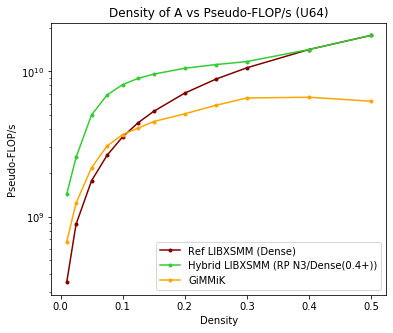

In [16]:
x_term="density"
plt.figure(figsize=(6,5))

hybrid_xvals, hybrid_avg, _ = get_local_upstream_perf(hybrid_runs, "vary_density/q_64", x_term)
rp_xvals, _, ref_avg = get_local_upstream_perf(rp_runs, "vary_density/q_64", x_term)

plt.plot(rp_xvals, ref_avg, label="Ref LIBXSMM (Dense)", color="maroon", marker=".")
plt.plot(hybrid_xvals, hybrid_avg, label="Hybrid LIBXSMM (RP N3/Dense(0.4+))", color="limegreen", marker=".")
plt.plot(gimmik_xvals, gimmik_avg, label="GiMMiK", color="orange", marker=".")  

plt.xlabel("Density")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.title("Density of A vs Pseudo-FLOP/s (U64)")
plt.legend()
plt.savefig("./../../../plots/libxsmm_vs_gimmik/synth/vary_density_64.pdf")
plt.show()

## Vary Num Unique

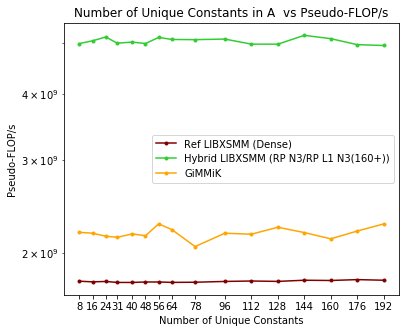

In [17]:
x_term="a_unique"
plt.figure(figsize=(6,5))

hybrid_xvals, hybrid_avg, _ = get_local_upstream_perf(hybrid_runs, "vary_unique", x_term)
gimmik_xvals, gimmik_avg = get_gimmik_perf(gimmik_runs, "vary_unique", x_term)
dense_xvals, _, dense_avg = get_local_upstream_perf(dense_runs, "vary_unique", x_term)

plt.plot(dense_xvals, dense_avg, label="Ref LIBXSMM (Dense)", color="maroon", marker=".")
plt.plot(hybrid_xvals, hybrid_avg, label="Hybrid LIBXSMM (RP N3/RP L1 N3(160+))", color="limegreen", marker=".")
plt.plot(gimmik_xvals, gimmik_avg, label="GiMMiK", color="orange", marker=".")  

plt.xlabel("Number of Unique Constants")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.xticks(hybrid_xvals)
plt.title("Number of Unique Constants in A  vs Pseudo-FLOP/s")
plt.legend()
plt.savefig("./../../../plots/libxsmm_vs_gimmik/synth/vary_unique.pdf")
plt.show()